In [13]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from pprint import pprint
from torch.utils.data import DataLoader
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.version.cuda)
import cv2
import numpy as np
from torchvision import transforms

True
2
11.1


In [14]:
from torchvision.transforms import functional as F
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform = None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 讀取圖片和遮罩
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        # print(f"Number of channels: { image.shape[2]}")
        # 適當的前處理...
        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))


        # image = image.transpose((2, 0, 1))
        # image = np.expand_dims(image, axis=0)
        # mask = np.expand_dims(mask, axis=0)

        # print("image: ", image.shape)
        # print("mask: ", mask.shape)
        
        # 將圖片和遮罩轉換為PyTorch的張量
        # image = torch.from_numpy(image.transpose((2, 0, 1))).float()
        # mask = torch.from_numpy(mask).unsqueeze(0).float()
        # image = image.transpose((2, 0, 1))  # 轉換為 (channels, height, width) 的格式
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = mask.astype(np.float32) / 255.0 

        if self.transform:
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            image = F.to_pil_image(image)
            image = self.transform(image)
            

            torch.manual_seed(seed)
            mask = F.to_pil_image(mask)
            mask = self.transform(mask)
            
            image = np.array(image)
            mask = np.array(mask)
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)
        return {'image': image, 'mask': mask}
    
# 定義遮罩轉換
transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # 隨機縮放並裁剪為 256x256
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),  # 隨機仿射變換
    transforms.RandomHorizontalFlip(),  # 隨機水平翻轉
    transforms.RandomVerticalFlip()  # 隨機垂直翻轉
])

In [15]:
from torch.utils.data import DataLoader

val_data_path = "ETT_v3/Fold2/val"
mask_val_path = "ETT_v3/Fold2/valannot"
val_files = os.listdir(val_data_path)
mask_val_files = os.listdir(mask_val_path)


train_data_path = "ETT_v3/Fold2/train"
mask_data_path = "ETT_v3/Fold2/trainannot"
train_files = os.listdir(train_data_path)
mask_files = os.listdir(mask_data_path)

test_data_path = "ETT_v3/Fold2/test"
mask_test_path = "ETT_v3/Fold2/testannot"
test_files = os.listdir(test_data_path)
mask_test_files = os.listdir(mask_test_path)



train_paths = [os.path.join(train_data_path, filename).replace('\\', '/') for filename in train_files]
mask_paths = [os.path.join(mask_data_path, filename).replace('\\', '/') for filename in mask_files]

val_paths = [os.path.join(val_data_path, filename).replace('\\', '/') for filename in val_files]
val_mask_files = [os.path.join(mask_val_path, filename).replace('\\', '/') for filename in mask_val_files]

test_paths = [os.path.join(test_data_path, filename).replace('\\', '/') for filename in test_files]
test_mask_files = [os.path.join(mask_test_path, filename).replace('\\', '/') for filename in mask_test_files]

assert set(train_files).isdisjoint(set(mask_data_path))
assert set(val_paths).isdisjoint(set(val_mask_files))
assert set(test_paths).isdisjoint(set(test_mask_files))

test_dataset = CustomDataset(test_paths, test_mask_files)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train size: {len(train_files)}")
print(f"Train size: {len(mask_files)}")

# dataset = CustomDataset(train_paths, mask_paths, transform=transformPic)
dataset = CustomDataset(train_paths, mask_paths, transform=transform)
val_dataset = CustomDataset(val_paths, val_mask_files)
# print(dataset[0])
train_dataloader2 = DataLoader(dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Train size: 287
Train size: 287


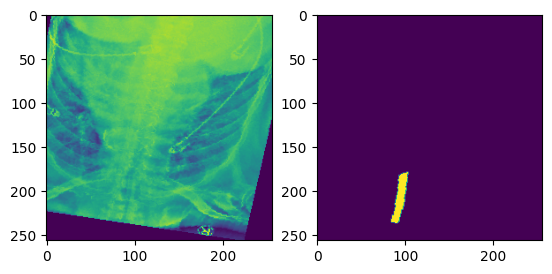

In [16]:
sample = dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [17]:
from pytorch_lightning.callbacks import Callback
class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]
        # image = (image - self.mean) / self.std  # Normalize images
        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4
        # print("image: ", image.shape)

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        # print("mask: ", mask.shape)

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)
        
        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        output = self.shared_step(batch, "valid")
        self.log('val_loss', output['loss'], prog_bar=True)
        # return self.shared_step(batch, "valid")
        return output

    def validation_epoch_end(self, outputs):
        
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=30,
    verbose=True,
    mode='min'
)

class IouCallBack(Callback):
    def __init__(self):
        super().__init__()
        self.train_ious = []
        self.valid_ious = []
    def on_validation_epoch_end(self, trainer, pl_modeule):
        self.train_ious.append(trainer.callback_metrics.get("train_dataset_iou"))
        self.valid_ious.append(trainer.callback_metrics.get("valid_dataset_iou"))

In [18]:
model = PetModel("UnetPlusPlus", "efficientnet-b7", in_channels=3, out_classes=1)
#UnetPlusPlus

In [19]:
# trainer = pl.Trainer(
#     gpus=1,
#     max_epochs=40,
# )
iou_callback = IouCallBack()
trainer = pl.Trainer(
    gpus=1,
    max_epochs=400,
    callbacks=[early_stop_callback, iou_callback]
)

trainer.fit(
    model,
    train_dataloader=train_dataloader2,
    val_dataloaders=val_dataloader

)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type         | Params
-----------------------------------------
0 | model   | UnetPlusPlus | 68.2 M
1 | loss_fn | DiceLoss     | 0     
-----------------------------------------
68.2 M    Trainable params
0         Non-trainable params
68.2 M    Total params
272.654   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 42/42 [00:47<00:00,  1.13s/it, loss=0.953, v_num=18, val_loss=1.000, valid_per_image_iou=0.000204, valid_dataset_iou=0.000165]

Metric val_loss improved. New best score: 0.993


Epoch 1: 100%|██████████| 42/42 [01:41<00:00,  2.42s/it, loss=0.905, v_num=18, val_loss=0.993, valid_per_image_iou=0.00238, valid_dataset_iou=0.00177, train_per_image_iou=0.0315, train_dataset_iou=0.0311]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 0.962


Epoch 2: 100%|██████████| 42/42 [01:58<00:00,  2.82s/it, loss=0.839, v_num=18, val_loss=0.962, valid_per_image_iou=0.0502, valid_dataset_iou=0.0662, train_per_image_iou=0.117, train_dataset_iou=0.101]    

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 0.900


Epoch 3: 100%|██████████| 42/42 [01:47<00:00,  2.56s/it, loss=0.761, v_num=18, val_loss=0.900, valid_per_image_iou=0.323, valid_dataset_iou=0.316, train_per_image_iou=0.238, train_dataset_iou=0.234]  

Metric val_loss improved by 0.110 >= min_delta = 0.0. New best score: 0.791


Epoch 4: 100%|██████████| 42/42 [02:00<00:00,  2.86s/it, loss=0.692, v_num=18, val_loss=0.791, valid_per_image_iou=0.481, valid_dataset_iou=0.479, train_per_image_iou=0.337, train_dataset_iou=0.338]

Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 0.701


Epoch 5: 100%|██████████| 42/42 [01:18<00:00,  1.86s/it, loss=0.604, v_num=18, val_loss=0.701, valid_per_image_iou=0.489, valid_dataset_iou=0.481, train_per_image_iou=0.418, train_dataset_iou=0.419]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 0.637


Epoch 6: 100%|██████████| 42/42 [00:37<00:00,  1.11it/s, loss=0.532, v_num=18, val_loss=0.637, valid_per_image_iou=0.501, valid_dataset_iou=0.487, train_per_image_iou=0.472, train_dataset_iou=0.476]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.576


Epoch 7: 100%|██████████| 42/42 [00:56<00:00,  1.35s/it, loss=0.471, v_num=18, val_loss=0.576, valid_per_image_iou=0.544, valid_dataset_iou=0.535, train_per_image_iou=0.519, train_dataset_iou=0.513]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.520


Epoch 8: 100%|██████████| 42/42 [01:57<00:00,  2.81s/it, loss=0.422, v_num=18, val_loss=0.520, valid_per_image_iou=0.546, valid_dataset_iou=0.539, train_per_image_iou=0.543, train_dataset_iou=0.547]

Metric val_loss improved by 0.048 >= min_delta = 0.0. New best score: 0.472


Epoch 9: 100%|██████████| 42/42 [01:57<00:00,  2.81s/it, loss=0.369, v_num=18, val_loss=0.472, valid_per_image_iou=0.569, valid_dataset_iou=0.558, train_per_image_iou=0.565, train_dataset_iou=0.574]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.459


Epoch 10: 100%|██████████| 42/42 [01:58<00:00,  2.81s/it, loss=0.337, v_num=18, val_loss=0.459, valid_per_image_iou=0.582, valid_dataset_iou=0.576, train_per_image_iou=0.590, train_dataset_iou=0.593]

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 0.381


Epoch 11: 100%|██████████| 42/42 [01:57<00:00,  2.81s/it, loss=0.293, v_num=18, val_loss=0.381, valid_per_image_iou=0.621, valid_dataset_iou=0.609, train_per_image_iou=0.610, train_dataset_iou=0.617]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.366


Epoch 12: 100%|██████████| 42/42 [01:58<00:00,  2.82s/it, loss=0.267, v_num=18, val_loss=0.366, valid_per_image_iou=0.631, valid_dataset_iou=0.613, train_per_image_iou=0.624, train_dataset_iou=0.623]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.334


Epoch 13: 100%|██████████| 42/42 [01:58<00:00,  2.81s/it, loss=0.245, v_num=18, val_loss=0.334, valid_per_image_iou=0.634, valid_dataset_iou=0.621, train_per_image_iou=0.629, train_dataset_iou=0.639]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.298


Epoch 14: 100%|██████████| 42/42 [01:58<00:00,  2.81s/it, loss=0.245, v_num=18, val_loss=0.298, valid_per_image_iou=0.660, valid_dataset_iou=0.645, train_per_image_iou=0.657, train_dataset_iou=0.659]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.297


Epoch 15: 100%|██████████| 42/42 [01:57<00:00,  2.81s/it, loss=0.227, v_num=18, val_loss=0.297, valid_per_image_iou=0.647, valid_dataset_iou=0.630, train_per_image_iou=0.667, train_dataset_iou=0.667]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.277


Epoch 16: 100%|██████████| 42/42 [01:33<00:00,  2.23s/it, loss=0.198, v_num=18, val_loss=0.277, valid_per_image_iou=0.668, valid_dataset_iou=0.653, train_per_image_iou=0.658, train_dataset_iou=0.668]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.277


Epoch 17: 100%|██████████| 42/42 [00:38<00:00,  1.09it/s, loss=0.203, v_num=18, val_loss=0.277, valid_per_image_iou=0.662, valid_dataset_iou=0.643, train_per_image_iou=0.679, train_dataset_iou=0.686]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.266


Epoch 19: 100%|██████████| 42/42 [00:33<00:00,  1.24it/s, loss=0.181, v_num=18, val_loss=0.268, valid_per_image_iou=0.664, valid_dataset_iou=0.646, train_per_image_iou=0.682, train_dataset_iou=0.685]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.253


Epoch 20: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s, loss=0.174, v_num=18, val_loss=0.253, valid_per_image_iou=0.669, valid_dataset_iou=0.650, train_per_image_iou=0.697, train_dataset_iou=0.697]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.245


Epoch 23: 100%|██████████| 42/42 [00:33<00:00,  1.24it/s, loss=0.158, v_num=18, val_loss=0.247, valid_per_image_iou=0.669, valid_dataset_iou=0.654, train_per_image_iou=0.712, train_dataset_iou=0.712]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.229


Epoch 26: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s, loss=0.15, v_num=18, val_loss=0.232, valid_per_image_iou=0.678, valid_dataset_iou=0.661, train_per_image_iou=0.714, train_dataset_iou=0.724] 

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.207


Epoch 30: 100%|██████████| 42/42 [00:33<00:00,  1.24it/s, loss=0.134, v_num=18, val_loss=0.209, valid_per_image_iou=0.708, valid_dataset_iou=0.690, train_per_image_iou=0.723, train_dataset_iou=0.727]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.205


Epoch 35: 100%|██████████| 42/42 [00:33<00:00,  1.24it/s, loss=0.129, v_num=18, val_loss=0.223, valid_per_image_iou=0.677, valid_dataset_iou=0.655, train_per_image_iou=0.741, train_dataset_iou=0.747]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.202


Epoch 40: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s, loss=0.119, v_num=18, val_loss=0.203, valid_per_image_iou=0.700, valid_dataset_iou=0.684, train_per_image_iou=0.750, train_dataset_iou=0.754]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.196


Epoch 41: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s, loss=0.12, v_num=18, val_loss=0.196, valid_per_image_iou=0.709, valid_dataset_iou=0.694, train_per_image_iou=0.751, train_dataset_iou=0.756] 

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.190


Epoch 51: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s, loss=0.108, v_num=18, val_loss=0.205, valid_per_image_iou=0.696, valid_dataset_iou=0.674, train_per_image_iou=0.757, train_dataset_iou=0.763]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.188


Epoch 52: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s, loss=0.111, v_num=18, val_loss=0.188, valid_per_image_iou=0.715, valid_dataset_iou=0.700, train_per_image_iou=0.757, train_dataset_iou=0.762]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.186


Epoch 57: 100%|██████████| 42/42 [00:33<00:00,  1.24it/s, loss=0.0988, v_num=18, val_loss=0.194, valid_per_image_iou=0.707, valid_dataset_iou=0.689, train_per_image_iou=0.770, train_dataset_iou=0.776]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.186


Epoch 59: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s, loss=0.103, v_num=18, val_loss=0.196, valid_per_image_iou=0.708, valid_dataset_iou=0.687, train_per_image_iou=0.769, train_dataset_iou=0.774] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.185


Epoch 65: 100%|██████████| 42/42 [00:34<00:00,  1.23it/s, loss=0.104, v_num=18, val_loss=0.187, valid_per_image_iou=0.720, valid_dataset_iou=0.700, train_per_image_iou=0.776, train_dataset_iou=0.784] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.180


Epoch 78: 100%|██████████| 42/42 [00:36<00:00,  1.14it/s, loss=0.09, v_num=18, val_loss=0.187, valid_per_image_iou=0.719, valid_dataset_iou=0.696, train_per_image_iou=0.770, train_dataset_iou=0.779]  

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.178


Epoch 79: 100%|██████████| 42/42 [00:37<00:00,  1.12it/s, loss=0.0946, v_num=18, val_loss=0.178, valid_per_image_iou=0.735, valid_dataset_iou=0.712, train_per_image_iou=0.775, train_dataset_iou=0.782]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.169


Epoch 80: 100%|██████████| 42/42 [00:37<00:00,  1.13it/s, loss=0.0931, v_num=18, val_loss=0.169, valid_per_image_iou=0.748, valid_dataset_iou=0.725, train_per_image_iou=0.770, train_dataset_iou=0.775]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.166


Epoch 85: 100%|██████████| 42/42 [00:37<00:00,  1.13it/s, loss=0.0897, v_num=18, val_loss=0.187, valid_per_image_iou=0.719, valid_dataset_iou=0.694, train_per_image_iou=0.782, train_dataset_iou=0.787]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.165


Epoch 90: 100%|██████████| 42/42 [00:37<00:00,  1.13it/s, loss=0.0883, v_num=18, val_loss=0.180, valid_per_image_iou=0.726, valid_dataset_iou=0.708, train_per_image_iou=0.782, train_dataset_iou=0.789]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.163


Epoch 93: 100%|██████████| 42/42 [01:00<00:00,  1.43s/it, loss=0.0883, v_num=18, val_loss=0.176, valid_per_image_iou=0.730, valid_dataset_iou=0.711, train_per_image_iou=0.785, train_dataset_iou=0.792]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.157


Epoch 96: 100%|██████████| 42/42 [01:58<00:00,  2.83s/it, loss=0.0892, v_num=18, val_loss=0.178, valid_per_image_iou=0.727, valid_dataset_iou=0.707, train_per_image_iou=0.785, train_dataset_iou=0.787]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.157


Epoch 114: 100%|██████████| 42/42 [00:40<00:00,  1.04it/s, loss=0.0844, v_num=18, val_loss=0.162, valid_per_image_iou=0.749, valid_dataset_iou=0.730, train_per_image_iou=0.795, train_dataset_iou=0.797]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.155


Epoch 118: 100%|██████████| 42/42 [00:39<00:00,  1.05it/s, loss=0.0854, v_num=18, val_loss=0.180, valid_per_image_iou=0.721, valid_dataset_iou=0.704, train_per_image_iou=0.792, train_dataset_iou=0.797]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.152


Epoch 148: 100%|██████████| 42/42 [00:40<00:00,  1.04it/s, loss=0.0757, v_num=18, val_loss=0.165, valid_per_image_iou=0.746, valid_dataset_iou=0.726, train_per_image_iou=0.793, train_dataset_iou=0.799]

Monitored metric val_loss did not improve in the last 30 records. Best score: 0.152. Signaling Trainer to stop.


Epoch 148: 100%|██████████| 42/42 [00:41<00:00,  1.02it/s, loss=0.0757, v_num=18, val_loss=0.182, valid_per_image_iou=0.721, valid_dataset_iou=0.701, train_per_image_iou=0.793, train_dataset_iou=0.803]


In [20]:
valid_metrics = trainer.validate(model, val_dataloaders=val_dataloader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


[{'val_loss': 0.18187887966632843,
  'valid_dataset_iou': 0.7007752060890198,
  'valid_per_image_iou': 0.7205528020858765}]


In [21]:
# run test dataset
test_metrics = trainer.test(model, test_dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]
[{'test_dataset_iou': 0.7565199136734009,
  'test_per_image_iou': 0.7787988185882568,
  'val_loss': 0.18187887966632843,
  'valid_dataset_iou': 0.7007752060890198,
  'valid_per_image_iou': 0.7205528020858765}]


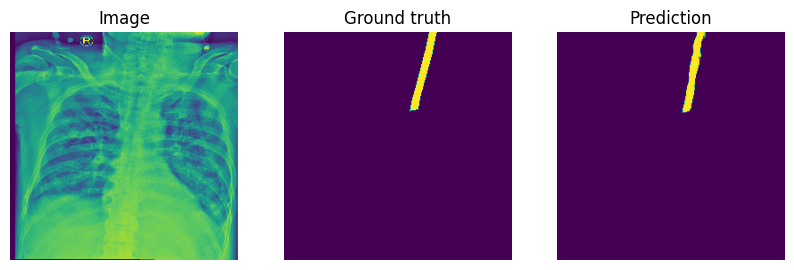

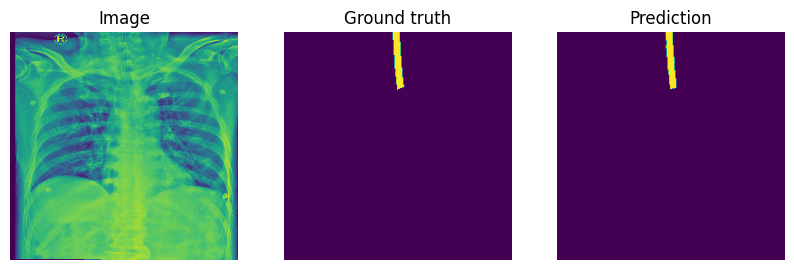

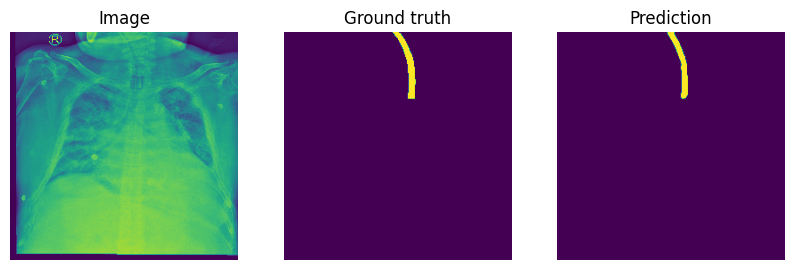

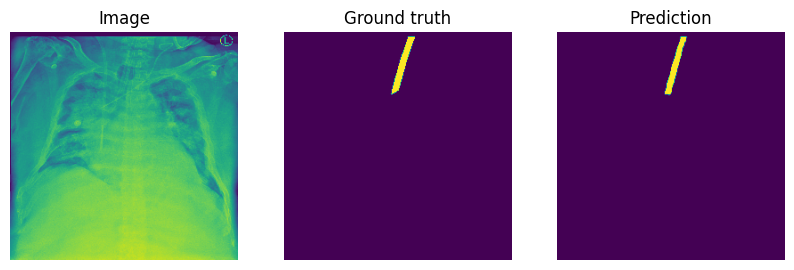

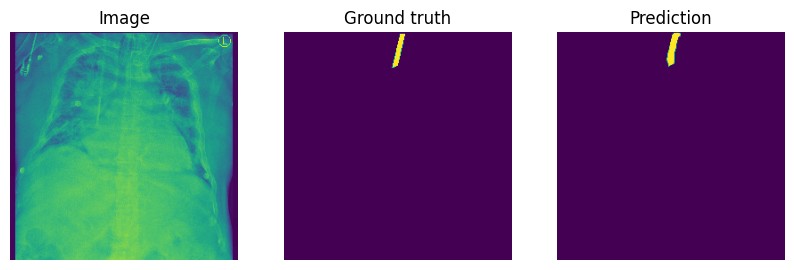

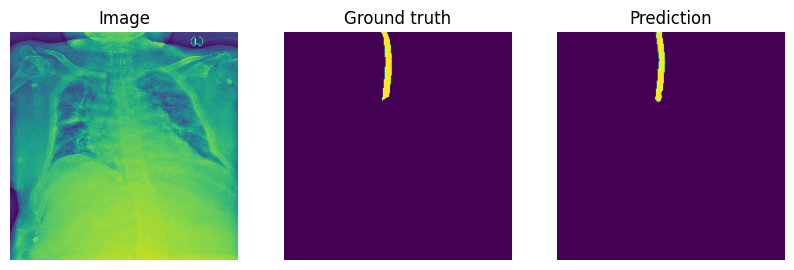

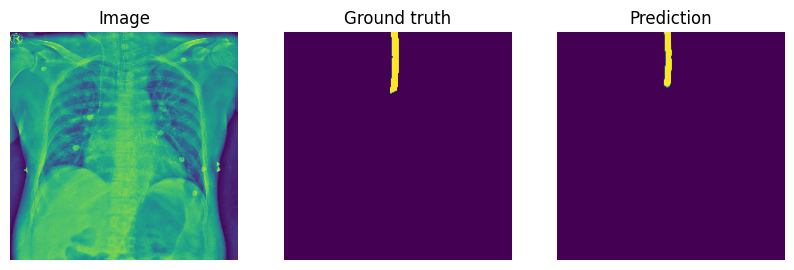

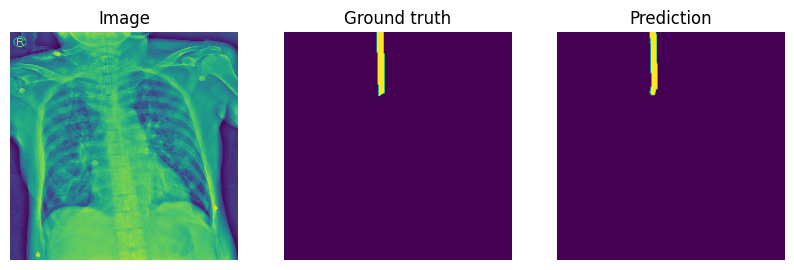

In [22]:
from itertools import islice
# 指定要顯示的批次索引
batch_index = 1

# 使用迭代器來訪問指定的批次
batch = next(islice(test_dataloader, batch_index, batch_index + 1))

# batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [23]:
import numpy as np

def calculate_metrics(pred_mask, gt_mask, pixel_size=1):
    # 確保 pred_mask 和 gt_mask 的維度一致
    assert pred_mask.shape == gt_mask.shape

    # 計算總像素數
    total_pixels = pred_mask.size

    # 計算真實值為 1 的像素數
    gt_positive_pixels = np.sum(gt_mask == 1)

    # 初始化結果字典
    results = {}

    # 找到真實遮罩中插管尾端的 y 座標
    gt_tube_end = np.where(gt_mask == 1)[0][-1]

    # 找到預測遮罩中插管尾端的 y 座標
    pred_tube_end = np.where(pred_mask == 1)[0][-1]

    # 計算插管尾端 y 座標的誤差（單位：像素）
    tube_end_error = abs(gt_tube_end - pred_tube_end)

    # 計算插管尾端 y 座標的誤差（單位：公分）
    tube_end_error_cm = tube_end_error * pixel_size
    results['tube_end_error_cm'] = tube_end_error_cm

    print('test: ', gt_tube_end)
    print('pred: ', pred_tube_end)
    print('cut: ', tube_end_error_cm, '\n---')

    # 計算誤差在 0.5cm 內的準確率
    accuracy_05 = 1.0 if tube_end_error_cm <= 0.5 else 0.0
    results['accuracy_05'] = accuracy_05 * 100
    # print('y座標像素誤差: ', tube_end_error)
    # print('這次有沒有超過0.5公分?')
    # print('y座標公分誤差: ', tube_end_error_cm)

    # 計算誤差在 1.0cm 內的準確率
    accuracy_10 = 1.0 if tube_end_error_cm <= 1.0 else 0.0
    results['accuracy_10'] = accuracy_10 * 100

    return results
def evaluate_model(model, test_dataset, pixel_size=1/72):
    model.eval()

    # 創建測試集的資料載入器
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # 初始化誤差指標列表
    metrics_list = []

    # 對每個測試圖片進行誤差計算
    with torch.no_grad():
        for batch in test_dataloader:
            image = batch["image"]
            gt_mask = batch["mask"].squeeze().numpy()

            # 進行推論
            logits_mask = model(image)
            pred_mask = logits_mask.sigmoid().squeeze().numpy()
            pred_mask = (pred_mask > 0.5).astype(np.uint8)

            # 計算誤差指標
            metrics = calculate_metrics(pred_mask, gt_mask, pixel_size=pixel_size)
            metrics_list.append(metrics)

    # 計算平均誤差指標
    avg_metrics = {
        "test_tube_end_error_cm": np.mean([m["tube_end_error_cm"] for m in metrics_list]),
        "test_accuracy_05": np.mean([m["accuracy_05"] for m in metrics_list]),
        "test_accuracy_10": np.mean([m["accuracy_10"] for m in metrics_list])
    }

    return avg_metrics, metrics_list
# 在測試集上評估模型
test_metrics, test_metrics_list = evaluate_model(model, test_dataset)

# 列印測試集的平均誤差指標
print("Test Set Average Metrics:")
print(test_metrics)

test:  70
pred:  72
cut:  0.027777777777777776 
---
test:  73
pred:  72
cut:  0.013888888888888888 
---
test:  47
pred:  39
cut:  0.1111111111111111 
---
test:  55
pred:  55
cut:  0.0 
---
test:  64
pred:  59
cut:  0.06944444444444445 
---
test:  60
pred:  67
cut:  0.09722222222222221 
---
test:  79
pred:  81
cut:  0.027777777777777776 
---
test:  76
pred:  75
cut:  0.013888888888888888 
---
test:  88
pred:  90
cut:  0.027777777777777776 
---
test:  64
pred:  63
cut:  0.013888888888888888 
---
test:  74
pred:  74
cut:  0.0 
---
test:  69
pred:  70
cut:  0.013888888888888888 
---
test:  39
pred:  38
cut:  0.013888888888888888 
---
test:  76
pred:  78
cut:  0.027777777777777776 
---
test:  68
pred:  61
cut:  0.09722222222222221 
---
test:  71
pred:  70
cut:  0.013888888888888888 
---
test:  87
pred:  90
cut:  0.041666666666666664 
---
test:  69
pred:  68
cut:  0.013888888888888888 
---
test:  96
pred:  99
cut:  0.041666666666666664 
---
test:  68
pred:  69
cut:  0.013888888888888888 
---

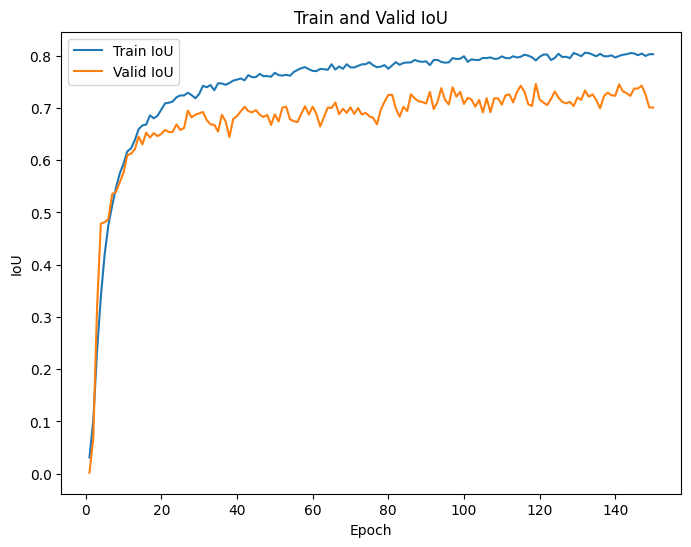

In [24]:
import matplotlib.pyplot as plt


feature_train_ious = iou_callback.train_ious[1:]
feature_valid_ious = iou_callback.valid_ious[1:]
train_ious_cpu = [iou.cpu().numpy() for iou in feature_train_ious]
valid_ious_cpu = [iou.cpu().numpy() for iou in feature_valid_ious]


epochs = range(1, len(train_ious_cpu) + 1)


plt.figure(figsize=(8, 6))
plt.plot(epochs, train_ious_cpu, label='Train IoU')
plt.plot(epochs, valid_ious_cpu, label='Valid IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('Train and Valid IoU')
plt.show()
